# Прогнозирование температуры звезды

 Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.

В базе обсерватории есть следующие характеристики уже изученных 240 звёзд.

    Относительная светимость L/Lo — светимость звезды относительно Солнца.
    Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.
    Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.
    Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.
    Тип звезды.
    Тип звезды	Номер, соответствующий типу
        Коричневый карлик	0
        Красный карлик	1
        Белый карлик	2
        Звёзды главной последовательности	3
        Сверхгигант	4
        Гипергигант	5
*    Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.

 <b>Необходимо разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды.</b><br>
 Метрика RMSE не должна превышать 4500.

## Прекод и получение данных

In [1]:
!pip install torch

In [2]:
import re
import numpy as np
import pandas as pd
import urllib.request

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error

import torch
import torch.nn as nn

import matplotlib.pyplot as plt
from matplotlib.patches import Patch 

In [3]:
np.random.seed(499)
torch.use_deterministic_algorithms(True)
torch.manual_seed(499)
get_yandex = lambda fn: urllib.request.urlretrieve(f"https://code.s3.yandex.net/datasets/{fn}", f"datasets/{fn}" )

In [4]:
rmse = lambda target,pred: mean_squared_error(target,pred,squared=False)
rmse.__name__ = 'RMSE'

all_regression_metrics = [rmse,r2_score]
def print_metrics( y,pr, metrics = all_regression_metrics ):
    scores = {}
    outline = ""
    for metric in metrics:
        scores[metric.__name__]= metric(y,pr)
        outline += f"{metric.__name__}: {scores[metric.__name__]}\t" 
    print(outline)    
        

### Загрузка данных

In [5]:
try:
    get_yandex("6_class.csv")
    df = pd.read_csv('datasets/6_class.csv',index_col=0)
except Exception as e:
    print(e)
    exit(1)
    
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB


,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


In [6]:
df.columns = ['tem','lum','rad','mag','type','color']
df.head()

,tem,lum,rad,mag,type,color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


## Предобработка и анализ данных

Проверим неопределенные значения и убедимся что их нет 

In [7]:
df.isna().sum()

tem      0
lum      0
rad      0
mag      0
type     0
color    0
dtype: int64

Для использвания в нейронной сети все входные данные должны быть числовыми .   
Светимость, радиус и величина являются нормальными числовыми колонками и нуждаются только в масштабировании.  


In [8]:
df.color.value_counts()

color
Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Blue white              3
Yellowish White         3
white                   3
Whitish                 2
Orange                  2
yellowish               2
Pale yellow orange      1
White-Yellow            1
Blue                    1
Yellowish               1
Orange-Red              1
Blue white              1
Blue-White              1
Name: count, dtype: int64

Цвет звезды может быть одним из 5 цветов (Red/Blue/Yellow/Orange/White) или комбинацией двух цветов.  
Перед преобразованием надо привести название цвета к стандартным наименованиям каждого цвета. Так как названия базовых цветов начинаются с разных букв можно урезать слова до первой буквы в нижнем регистре и упорядочить буквы в получившейся  строке - это даст все возможные классы

In [9]:
df.type.value_counts()

type
0    40
1    40
2    40
3    40
4    40
5    40
Name: count, dtype: int64

Колонка "класс звезды" фактически является категориальной , причем по каждой каждому классу отобрано одинаковое количесто объектов

### Преобразования цвета 

Хотя одно-двухбуквенные названимя цветов можно закодировать непосредственно в OneHotEncoder, при этом потеряется инофрмация о близости смешанных цветов к каждому из компонентов. Поэтому мне кажется более правильным кодировать в одтельную колонку пять базовых цветов, а для смешанных цветов   выводить их сочетания в соответствующих колонках 

In [10]:
color_chars= ['b','o','r','w','y']
def enc_color(colorname):
    colors = re.findall(r'\b(\w)' ,colorname.lower())      # first letters of base color names  
    colors = [ re.sub('p','w',c) for c in colors ]         # to catch  only case where 'pale' apparently means 'white'
    return ( { c: int(c in colors) for c in color_chars })

df_color = pd.DataFrame.from_records( df.color.apply(enc_color) ,index = df.index)
df_color.tail(60 )

,b,o,r,w,y
180,0,0,1,0,0
181,0,0,1,0,0
182,0,0,1,0,0
183,0,0,1,0,0
184,0,0,1,0,0
185,0,0,1,0,0
186,0,0,1,0,0
187,0,0,1,0,0
188,0,0,1,0,0
189,0,0,1,0,0


### Преобразования типа

In [11]:
ohe = OneHotEncoder(sparse=False,drop='first')
df_type = pd.DataFrame( ohe.fit_transform(df[['type']]) )

C:\Users\Leonid\anaconda3\envs\py39\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Проверка числовых колонок

Перед преобразованием колонок проверим наличие выбросов

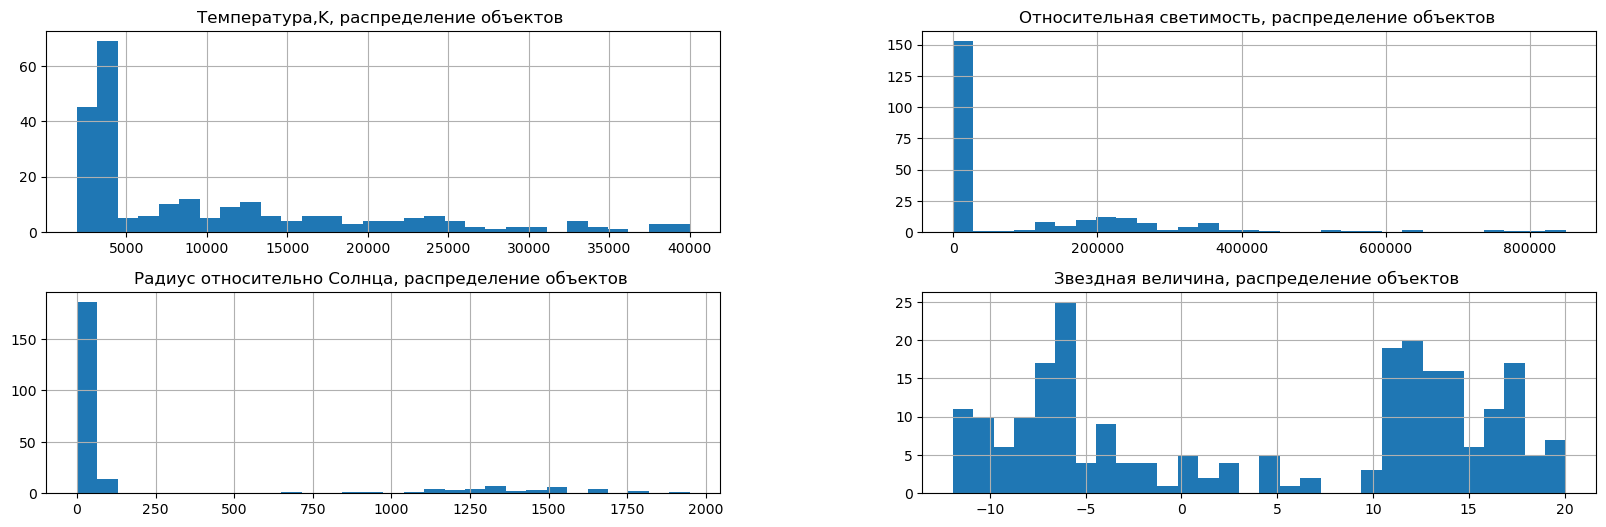

In [12]:
num_features = ['lum','rad','mag']
num_cols = ['tem'] + num_features
axes = df[num_cols].hist(figsize=(20,6),bins=30).flatten();
for ax,title in zip(axes,['Температура,K','Относительная светимость','Радиус относительно Cолнцa','Звездная величина']):
    ax.set_title( title+', распределение объектов ') 

Колонка звездной величины выглядит довольно естественно, по остальным вроде бы  есть выбросы, но можно убедиться что это специфическая зависимость от класса звезды 

In [13]:
df[df.lum>60_000].type.value_counts()

type
4    40
5    40
3     6
Name: count, dtype: int64

Верхнмй хвост по светимости состоит из звезд 4и 5го классов и их распределение естественно 

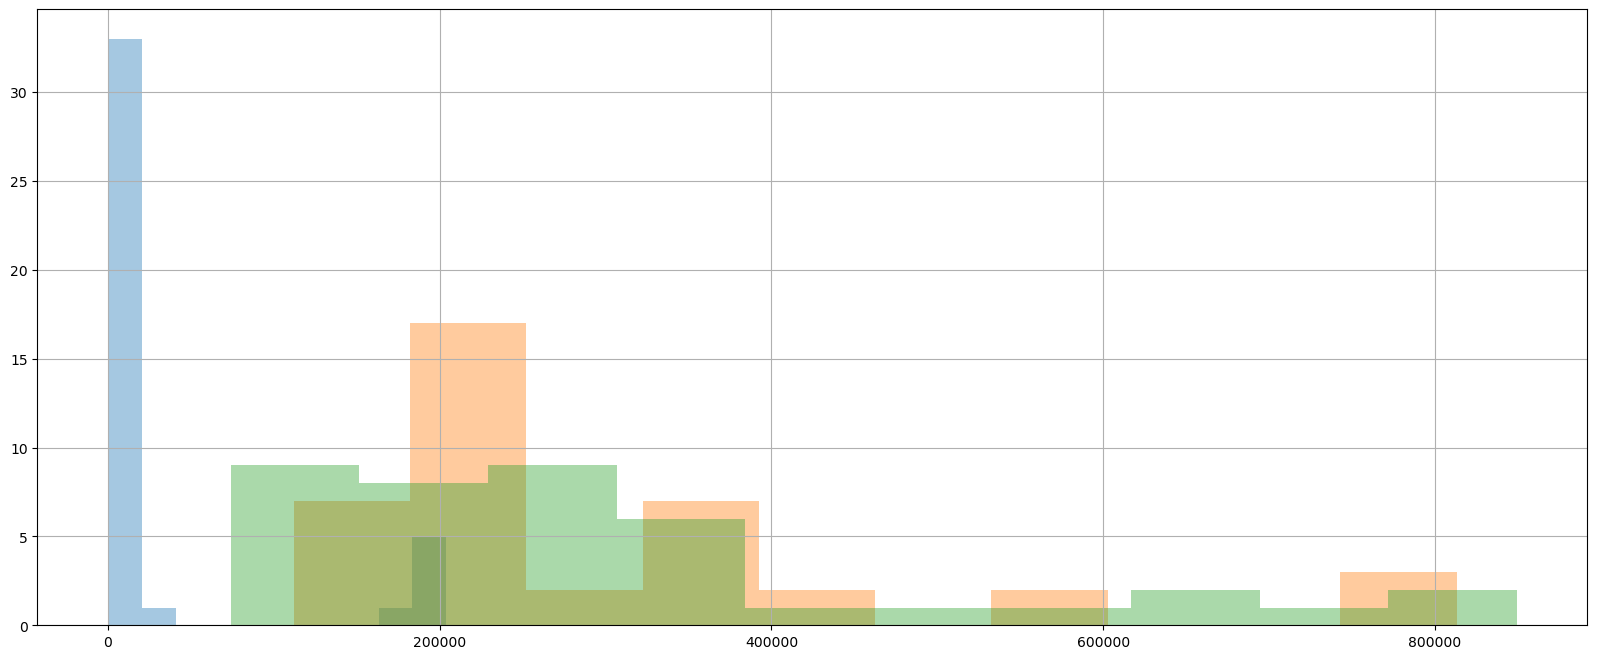

In [14]:
for ty in range(3,6):
    df.lum[df.type==ty].hist(figsize=(20,8),alpha = .4);

Некоторые сомнения вызывают 6 звезд главной последовательности в районе 200К, но нужно уточнять у астрофизиков, возможно ли это 

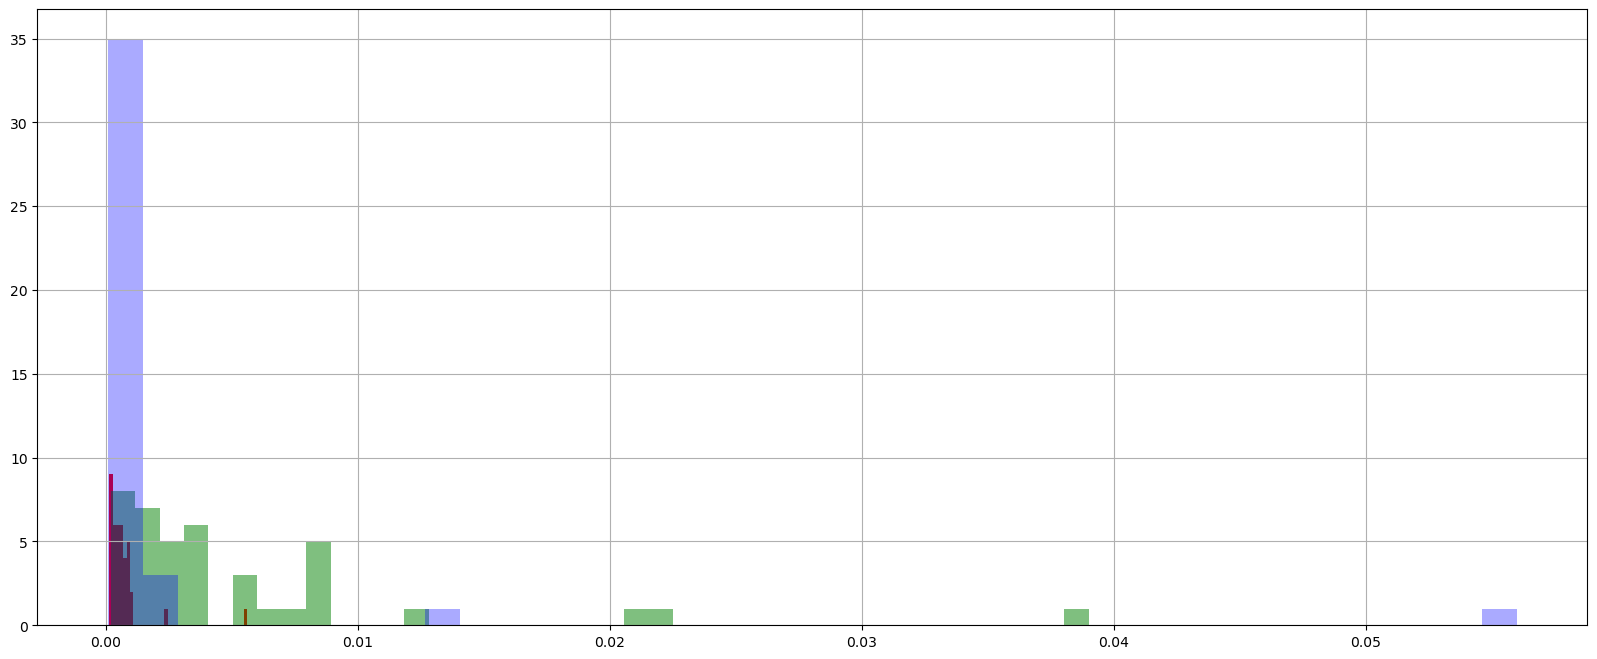

In [15]:
for ty in range(3):
    df.lum[df.type==ty].hist(bins=40, figsize=(20,8),alpha = 1/(ty+1) ,color = 'rgb'[ty])

У карликов распредеение светимости тоже выглядит естествнно, хотя масштаб существенно различается 

In [16]:
df[df.rad>400].type.value_counts()

type
5    40
Name: count, dtype: int64

Весь верхний хвост по радиусу состоит из звездв 5го класса и только из них

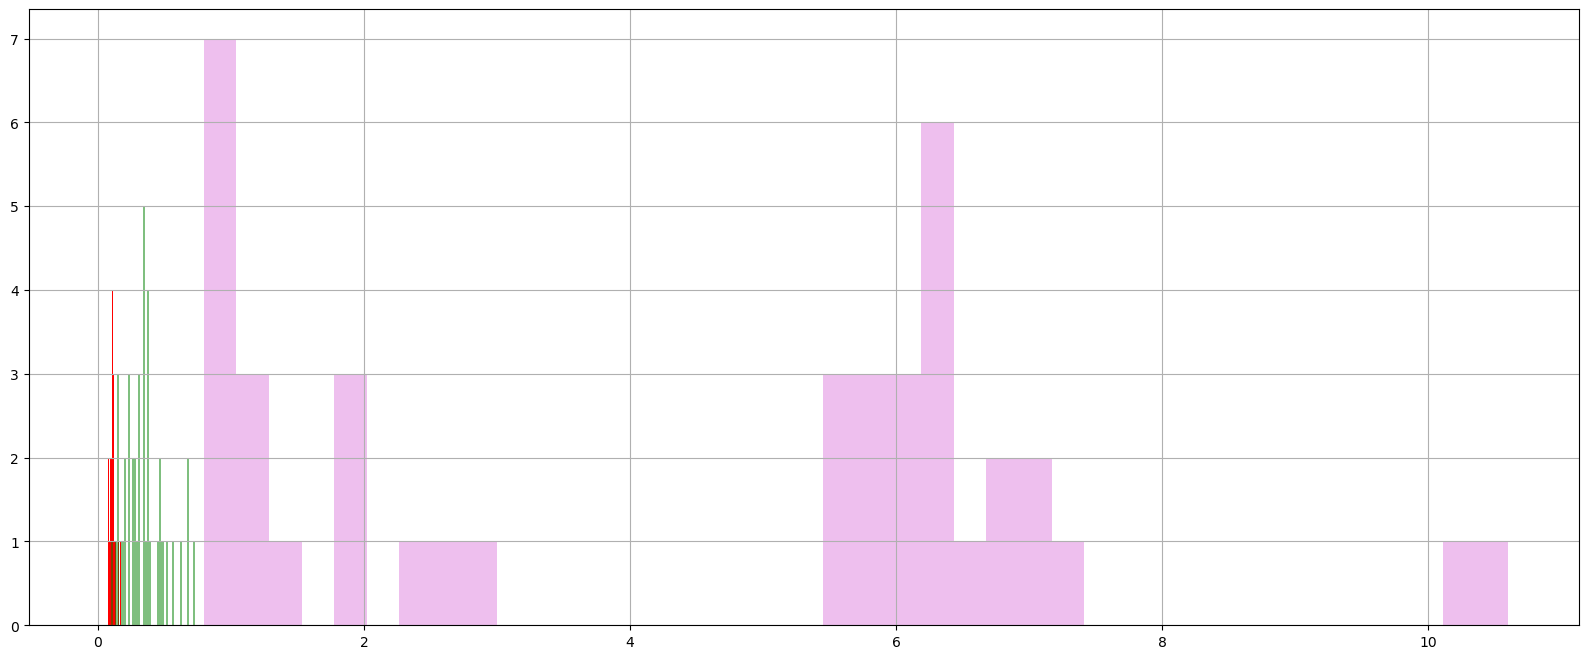

In [17]:
for ty in range(4):
    df.rad[df.type==ty].hist(bins=40, figsize=(20,8),alpha = 1/(ty+1) ,color = 'rgbm'[ty])

В целом , можно сказать , что числовые характеристики очень сильно зависят от класса звезда, переход к следующему классу может вызвать изменение на порядок. Некоторые гистограммы вызвают впоросы. Но вряд ли можно менять данные или выбрасывать  объекты без консультаций со специалистами.

### Корреляция признаков

In [18]:
df[num_cols].corr()

,tem,lum,rad,mag
tem,1.000000,0.393404,0.064216,-0.420261
lum,0.393404,1.000000,0.526516,-0.692619
rad,0.064216,0.526516,1.000000,-0.608728
mag,-0.420261,-0.692619,-0.608728,1.000000


In [19]:
df

,tem,lum,rad,mag,type,color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red
...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,5,Blue
236,30839,834042.000000,1194.0000,-10.63,5,Blue
237,8829,537493.000000,1423.0000,-10.73,5,White
238,9235,404940.000000,1112.0000,-11.23,5,White


Есть сильная антикорреляция между величиной и класс звезды. Но так как класс - это фактически категориальная переменная и я ожидаю , что нейросеть будет проводить оценку "внутри" класса, я принял решение оставить как есть .  
В конце концов, мы не может выкинуть класс из модели,он слишком важен.
Возможно , следует провести отдельное масштабирование дял каждого класса и посмотреть , улучшит ли оно результат

### Train- test split

Создадим для работы новый датафрейм из преобразованных колонок

In [20]:
X = pd.concat([df[num_features],df_color,df_type], axis=1)
y = df[['tem']]

И разобьем на тренировочный и тестовый наборы.  
Так как класс звезды играет огромную роль в модели (фактически рабивает её на несколько независимых) , я считаю , что разбиение дожно быть стратифицировано именно по классу.

In [21]:
X_tr,X_te,y_tr,y_te = train_test_split(X,y,test_size = .25, shuffle=True, stratify = df.type)
i_tr = y_tr.index
i_te = y_te.index

#### Масштабирование

In [22]:
X_tr = X_tr.copy()
X_te = X_te.copy()

Здесь пришлось явно скопировать фреймы , чтобы избежать <i>SettingWithCopyWarning<i>

In [23]:
scl = StandardScaler()
scl.fit(X_tr[num_features])
X_tr[num_features] = scl.transform(X_tr[ num_features] )
X_te[num_features] = scl.transform(X_te[ num_features] )

## Построение базовой нейронной сети

In [24]:
X_tr = torch.FloatTensor(X_tr.values)
X_te = torch.FloatTensor(X_te.values)
y_tr = torch.FloatTensor(y_tr.values)
y_te = torch.FloatTensor(y_te.values)

Метрикой по условию выбрана RMSE, соответственно  функцией потерь естественно взять MSELoss
Для скорости обучения и инициализации весов взяты типичные значения  из упражнений  

In [25]:
n_in_neurons = len(X.columns)
n_hidden_neurons_1 = 10
n_hidden_neurons_2 = 5
n_out_neurons = 1 

net = nn.Sequential(
    nn.Linear(n_in_neurons,n_hidden_neurons_1),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_2, n_out_neurons)#, 
)

def init_weights(layer):
    if type(layer) == nn.Linear: 
        nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu') 
net.apply(init_weights)        

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

loss = nn.MSELoss()

In [26]:
num_epochs = 100

for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    preds = net.forward(X_tr) 
       
    loss_value = loss(preds, y_tr)
    loss_value.backward()
            
    optimizer.step()
    
    if epoch % 10 == 0:
        net.eval()
        with torch.no_grad():
            test_preds = net.forward(X_te)
            print_metrics(y_te.numpy(),test_preds.detach().numpy())

RMSE: 14194.3486328125	r2_score: -1.3110980943190746	
RMSE: 14194.21875	r2_score: -1.311055642078074	
RMSE: 14194.078125	r2_score: -1.3110095937934756	
RMSE: 14193.943359375	r2_score: -1.3109657247380624	
RMSE: 14193.810546875	r2_score: -1.3109223482507684	
RMSE: 14193.6611328125	r2_score: -1.310873965596667	
RMSE: 14193.4990234375	r2_score: -1.3108213635656263	
RMSE: 14193.32421875	r2_score: -1.3107643347303575	
RMSE: 14193.1416015625	r2_score: -1.3107047962160703	
RMSE: 14192.955078125	r2_score: -1.3106441482047595	


:( Сеть вообще не обучилась , попробуем увеличить скорость и продлить обучение 

In [27]:
n_in_neurons = len(X.columns)
n_hidden_neurons_1 = 10
n_hidden_neurons_2 = 5
n_out_neurons = 1 

net1 = nn.Sequential(
    nn.Linear(n_in_neurons,n_hidden_neurons_1),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_2, n_out_neurons)#, 
)

def init_weights(layer):
    if type(layer) == nn.Linear: 
        nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu') 
net1.apply(init_weights)        

optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)    # increase learnig rate  10 times

loss = nn.MSELoss()

In [28]:
num_epochs = 1000             # increase num_epochs 10 times
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    preds = net.forward(X_tr) 
       
    loss_value = loss(preds, y_tr)
    loss_value.backward()
            
    optimizer.step()
    
    if epoch % 100 == 0:
        net1.eval()
        test_preds = net.forward(X_te)
        print_metrics(y_te.numpy(),test_preds.detach().numpy() )

RMSE: 14192.625	r2_score: -1.310537017554195	
RMSE: 13964.619140625	r2_score: -1.2368950595344619	
RMSE: 12223.6357421875	r2_score: -0.7139106471988144	
RMSE: 8916.2158203125	r2_score: 0.08809703468890984	
RMSE: 6608.05419921875	r2_score: 0.499118991300904	
RMSE: 5832.22998046875	r2_score: 0.6098274839448721	
RMSE: 5555.3037109375	r2_score: 0.64600018993652	
RMSE: 5365.9541015625	r2_score: 0.6697206885665181	
RMSE: 5211.22607421875	r2_score: 0.6884933975638869	
RMSE: 5079.70947265625	r2_score: 0.7040181471937381	


Результат уже более-менее вменяемый, но 

### Сравним с линейной регрессией

In [29]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_tr,y_tr)
y_pr = model.predict(X_te)
print_metrics(y_te,y_pr)

RMSE: 4530.525390625	r2_score: 0.7645576577009979	


Простая регрессия считает лучше, чем нейронная сеть :(

### Иллюстрация

Диаграмма, рекомендованная в задании (не совсем понял , какой должна быть, в таком формате она показывает только предсказания для тренировочного набора )

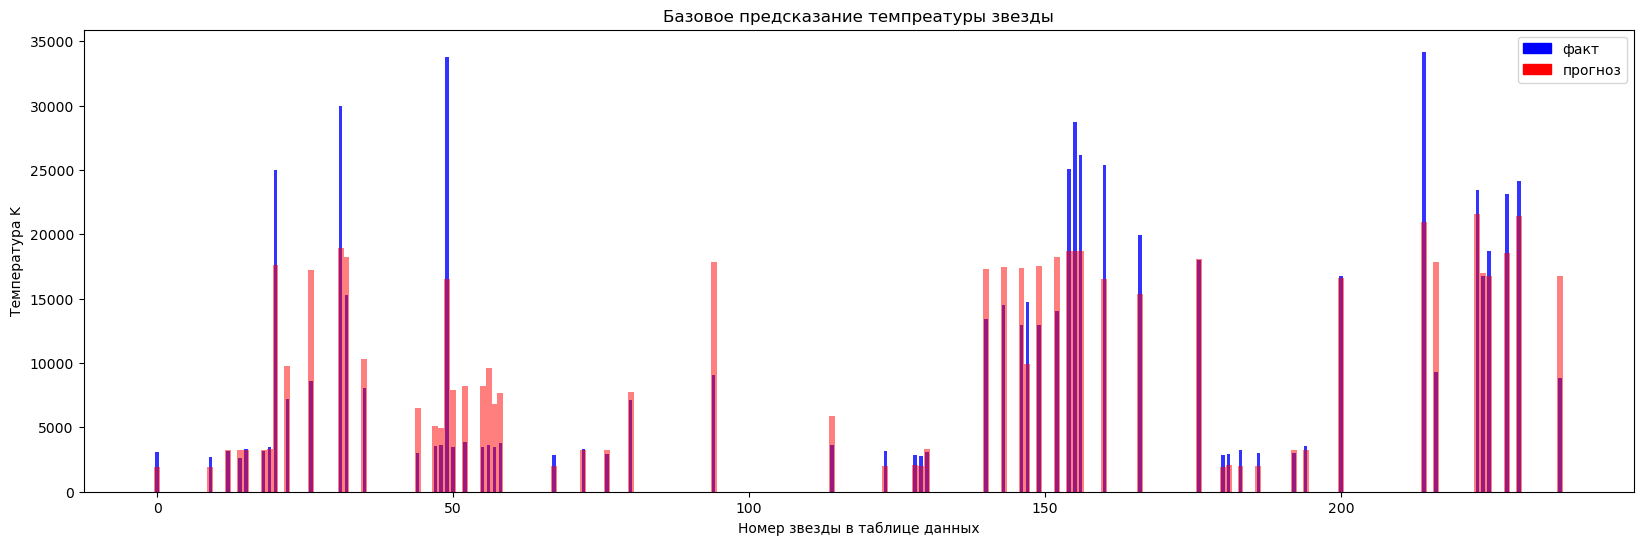

In [30]:
def plot_match_bar( d_te, title):
    fig, ax = plt.subplots(figsize=(20,6))
    ax.set_title('Базовое предсказание темпреатуры звезды')
    ax.set_xlabel('Номер звезды в таблице данных')
    ax.set_ylabel('Температура K')
    colors = { 'target':'blue','pred':'red'} 
    ax.bar(d_te.index,d_te.target,color='b',alpha =.8,width = .6);
    ax.bar(d_te.index,d_te.pred,color='r',alpha =.5,width=1);
    ax.legend(handles= [Patch(color='b', label='факт'),Patch(color='r', label='прогноз')] );

plot_match_bar( pd.DataFrame({'target': y_te.numpy().flatten(),'pred':test_preds.detach().numpy().flatten()},index= i_te)
               ,'Базовое предсказание температуры звезды')


Судя по картинке, нейросеть занижает температуру для горячих звезд  и завышает - для холодных 

## Улучшение нейронной сети

In [31]:
      
class Net(nn.Sequential):
    def __init__(self):
        super(Net, self).__init__() 



 Я решил , что для новой задачи проще написать свою тестовою решетку.  
 Во -первых создаем класс для прогона и записи результата одного обучения  

In [32]:
class Teacher:
    base_params = {
        'levels': [13,6,4,1],
        'weights':[0.5,0.1],
        'bias':[0.2,0.3],
        'acts':[nn.ReLU()] ,
        'fans':['fan_in'],
        'init_methods':[nn.init.kaiming_uniform_],
        'learn_rate':.1,
        'loss':nn.MSELoss(),
        'metric': rmse,
        'label':''
    }

    def __init__(self,params,random_state = 49999):
        print(f"---> Testing with params {params}")
        self.random_state = random_state
        params = self.base_params | params
        depth = len(params['levels'])
        arrange_array = lambda ar: (ar*int(depth/len(ar)))[:depth]
        self.levels = params['levels']
        self.activators = arrange_array(params['acts']) 
        self.fans = arrange_array(params['fans'])
        self.init_methods = arrange_array(params['init_methods'])    
        self.create_net()
        self.learn_rate = params['learn_rate']
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=self.learn_rate)
        self.loss = params['loss']
        self.epochs = params['epochs']
        self.eval_rate = params['eval_rate']
        self.eval_step =int(self.epochs*self.eval_rate)
        self.metric = params['metric']
        self.results = {}
        self.label = params['label']
        self.best = 10_000
        self.best_epoch=0
        self.final_metric =0 
        self.final_preds = []
 
        
    def create_net(self):
        torch.manual_seed(self.random_state)
        self.net = Net()
        for lev in range(len(self.levels)-1):
            ll = nn.Linear(self.levels[lev],self.levels[lev+1])
            self.init_methods[lev](ll.weight,mode=self.fans[lev] ,nonlinearity='relu')
            self.net.add_module('Linear_'+str(lev),ll)
            if lev < len(self.levels)-2:
                self.net.add_module('Activator_'+str(lev),self.activators[lev] )
        
     
    def run(self):   
        for epoch in range(self.epochs):
            self.optimizer.zero_grad()

            preds = self.net.forward(X_tr) 
            loss_value = self.loss(preds, y_tr)
            loss_value.backward()
            self.optimizer.step()
            
            if (epoch % self.eval_step == 0) or (epoch==self.epochs-1) :
                self.net.eval()
                with torch.no_grad():
                    test_preds = self.net.forward(X_te)
                    res = self.metric(y_te.numpy(),test_preds.detach().numpy() )
                    print(f"epoch {epoch},\tmetric {res:.4f}")
                    self.results[epoch] = res
                    if res < self.best:
                        self.best = res
                        self.best_epoch = epoch
            self.final_preds = test_preds
            self.final_metric = res
        print(f"best {self.best:.4f} \t (best epoch: {self.best_epoch} ) ---> ")

 И серию тестов с общим количеством эпох и оценочных этапов (eval_rate - доля оценочных этапов)

In [33]:
class TestSuit:
    def __init__(self,params_array,epochs={'epochs':100,'eval_rate':.1},random_state=49999):
        self.suit = params_array  
        self.epochs= epochs                # the same step for all tests  
        self.results = {}
        self.random_state = random_state
        

    def run(self):
        for params in self.suit:
            params=self.epochs|params                               
            t = Teacher(params,self.random_state)
            t.run()
            self.results[t.label] = t.results 

    def plot(self,ylim=(3500,7000),figsize=(20,8),styles=[*'rygbkm']):
        fig ,ax = plt.subplots( figsize=figsize )
        ax.set_ylim(ylim)
        styles.reverse()
        ax.set_xlabel('epochs passed')
        ax.set_ylabel('RMSE score')
        ticks = [ *range( int(1/self.epochs['eval_rate']) )]
        ticks_labels = [ *range(0,self.epochs['epochs'],int(self.epochs['eval_rate']*self.epochs['epochs']) )]
        ax.set_xticks(ticks)    
        ax.set_xticklabels(ticks_labels )    

        for (l,r)  in self.results.items():
            ax.plot( r.values() , styles.pop() ,label=l) 
        ax.legend() ; 



###  Предварительный тест для оценки конфигурации

На этой стадии поведем грубую оценку - определим количество слоев и эпох. на которых достигаются лучшие результаты   
Я не знаю, как лучше выбирать размеры слоев, поэтому обычно просто равномерно  снижаю их с 13 до 1   
Но для 4 слойной сети проверяется также 2х-кратное снижение на каждом слое (neg exponent)  

In [34]:
tests = [
    { 'levels': [13,5,1], 'label' : '3 layers uniform'},
    { 'levels': [13,8,4,1], 'label' : '4 layers uniform'},
    { 'levels': [13,6,3,1], 'label' : '4 layers negative exp sizes'} , 
    { 'levels': [13,10,7,4,1], 'label' : '5 layers uniform'},
    { 'levels': [13,11,9,7,5,3,1], 'label' : '7 layers uniform'},
    { 'levels': [*range(13,0,-1)], 'label' : '13 layers uniform' }  # 1..13
] 

На предварительном тестировании у меня появилось подозрезние, что random seed может сильно влиять на результат дя некоторых конфигураций, пожтому сначала проводим тестирование с одинаковыми параметрами и различными random_stateЮ чтобы проверить стабильность системы
Все тесты идут для 400 эпох с оценкой через 10 

---> Testing with params {'epochs': 400, 'eval_rate': 0.04, 'levels': [13, 5, 1], 'label': '3 layers uniform'}
epoch 0,	metric 14192.8486
epoch 16,	metric 14148.7607
epoch 32,	metric 14019.9814
epoch 48,	metric 13775.3379
epoch 64,	metric 13401.7666
epoch 80,	metric 12907.3408
epoch 96,	metric 12314.4014
epoch 112,	metric 11651.9248
epoch 128,	metric 10942.4570
epoch 144,	metric 10204.6494
epoch 160,	metric 9466.7471
epoch 176,	metric 8760.8223
epoch 192,	metric 8114.7544
epoch 208,	metric 7548.0493
epoch 224,	metric 7070.4399
epoch 240,	metric 6682.6562
epoch 256,	metric 6377.9922
epoch 272,	metric 6144.3354
epoch 288,	metric 5966.8716
epoch 304,	metric 5831.0576
epoch 320,	metric 5724.7588
epoch 336,	metric 5638.9707
epoch 352,	metric 5567.4634
epoch 368,	metric 5506.0366
epoch 384,	metric 5453.4463
epoch 399,	metric 5411.7231
best 5411.7231 	 (best epoch: 399 ) ---> 
---> Testing with params {'epochs': 400, 'eval_rate': 0.04, 'levels': [13, 8, 4, 1], 'label': '4 layers uniform'}
epo

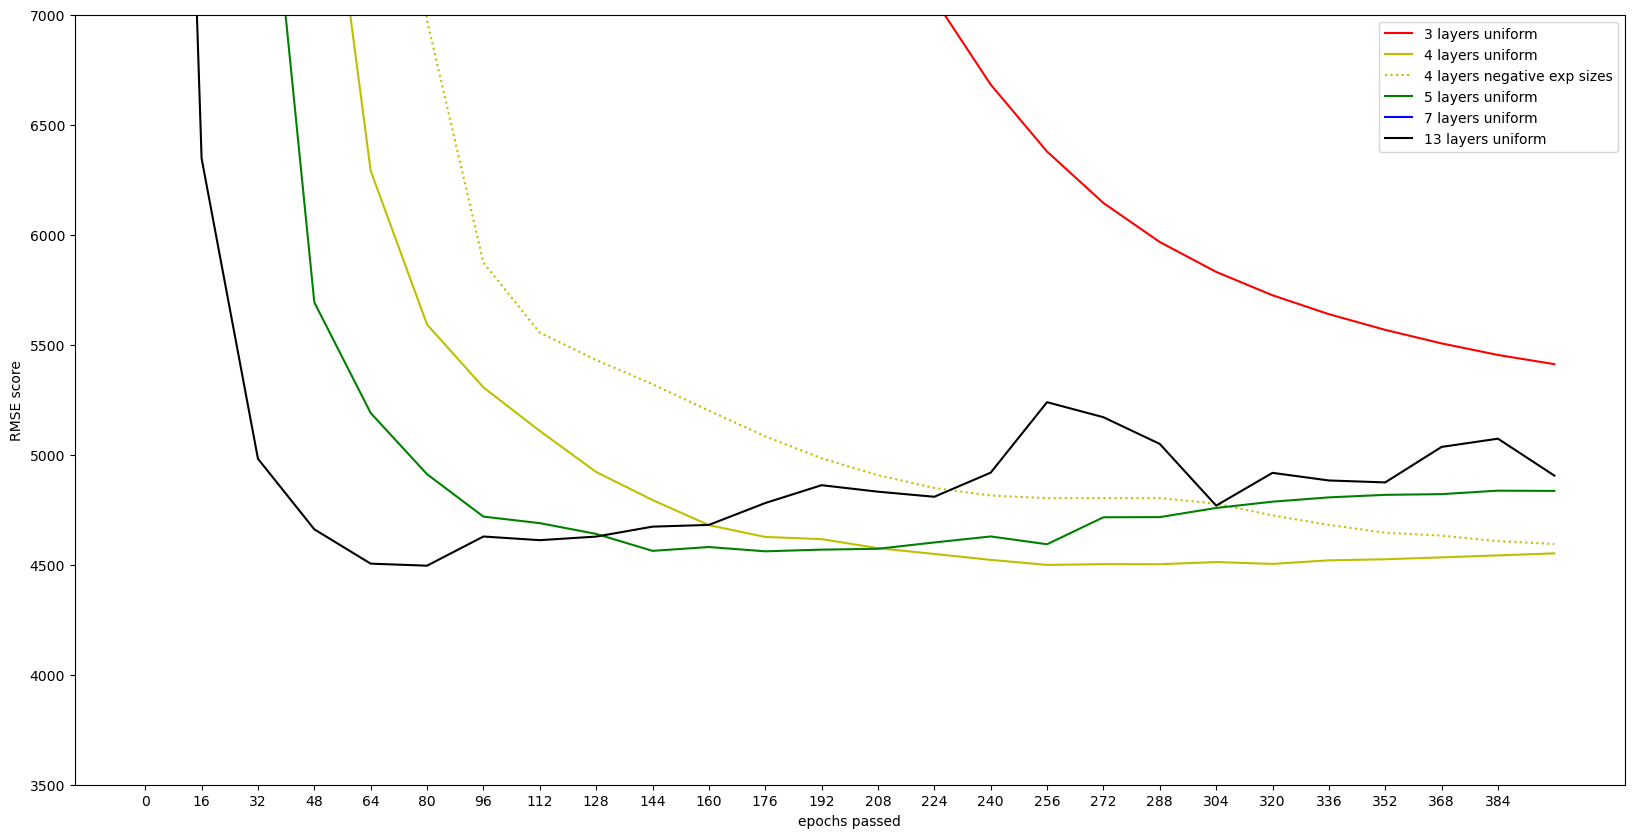

In [35]:
ts = TestSuit(tests,epochs={'epochs':400,'eval_rate':.04},random_state = 123456789)
ts.run() 
ts.plot(ylim=(3500,7000),figsize=(20,10), styles=['r', 'y', 'y:', 'g', 'b', 'k'] )

---> Testing with params {'epochs': 400, 'eval_rate': 0.04, 'levels': [13, 5, 1], 'label': '3 layers uniform'}
epoch 0,	metric 14193.3516
epoch 16,	metric 14157.0146
epoch 32,	metric 14056.2891
epoch 48,	metric 13869.9570
epoch 64,	metric 13576.6562
epoch 80,	metric 13147.1074
epoch 96,	metric 12581.8477
epoch 112,	metric 11906.8232
epoch 128,	metric 11158.9971
epoch 144,	metric 10374.0381
epoch 160,	metric 9584.0674
epoch 176,	metric 8824.0537
epoch 192,	metric 8132.1382
epoch 208,	metric 7529.5942
epoch 224,	metric 7032.5024
epoch 240,	metric 6644.1851
epoch 256,	metric 6349.4082
epoch 272,	metric 6131.7720
epoch 288,	metric 5969.3906
epoch 304,	metric 5837.8657
epoch 320,	metric 5732.0176
epoch 336,	metric 5647.7261
epoch 352,	metric 5578.2632
epoch 368,	metric 5517.9453
epoch 384,	metric 5464.0474
epoch 399,	metric 5418.2041
best 5418.2041 	 (best epoch: 399 ) ---> 
---> Testing with params {'epochs': 400, 'eval_rate': 0.04, 'levels': [13, 8, 4, 1], 'label': '4 layers uniform'}
epo

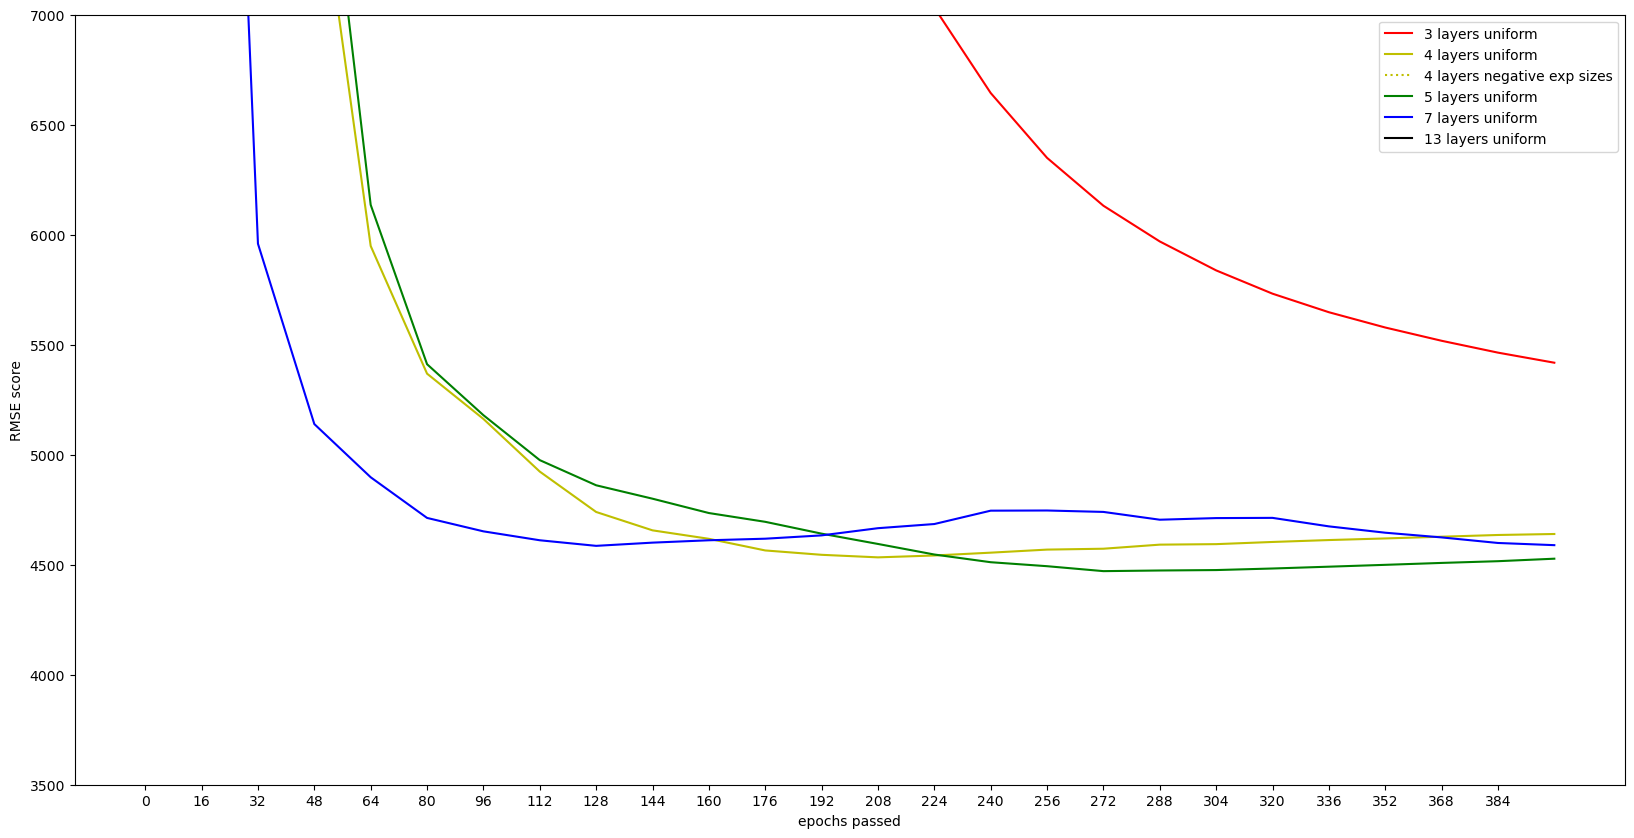

In [36]:
ts = TestSuit(tests,epochs={'epochs':400,'eval_rate':.04},random_state = 49999)
ts.run() 
ts.plot(ylim=(3500,7000),figsize=(20,10), styles=['r', 'y', 'y:', 'g', 'b', 'k'] )

---> Testing with params {'epochs': 400, 'eval_rate': 0.04, 'levels': [13, 5, 1], 'label': '3 layers uniform'}
epoch 0,	metric 14192.6816
epoch 16,	metric 14155.6865
epoch 32,	metric 14055.1846
epoch 48,	metric 13870.4238
epoch 64,	metric 13591.2852
epoch 80,	metric 13219.6963
epoch 96,	metric 12767.1699
epoch 112,	metric 12250.7656
epoch 128,	metric 11685.8789
epoch 144,	metric 11081.6680
epoch 160,	metric 10450.7783
epoch 176,	metric 9813.3496
epoch 192,	metric 9189.6045
epoch 208,	metric 8597.9424
epoch 224,	metric 8054.0854
epoch 240,	metric 7569.4507
epoch 256,	metric 7150.3008
epoch 272,	metric 6797.8247
epoch 288,	metric 6508.7910
epoch 304,	metric 6276.5498
epoch 320,	metric 6092.3257
epoch 336,	metric 5946.6777
epoch 352,	metric 5830.7656
epoch 368,	metric 5737.1484
epoch 384,	metric 5660.0269
epoch 399,	metric 5598.8599
best 5598.8599 	 (best epoch: 399 ) ---> 
---> Testing with params {'epochs': 400, 'eval_rate': 0.04, 'levels': [13, 8, 4, 1], 'label': '4 layers uniform'}
ep

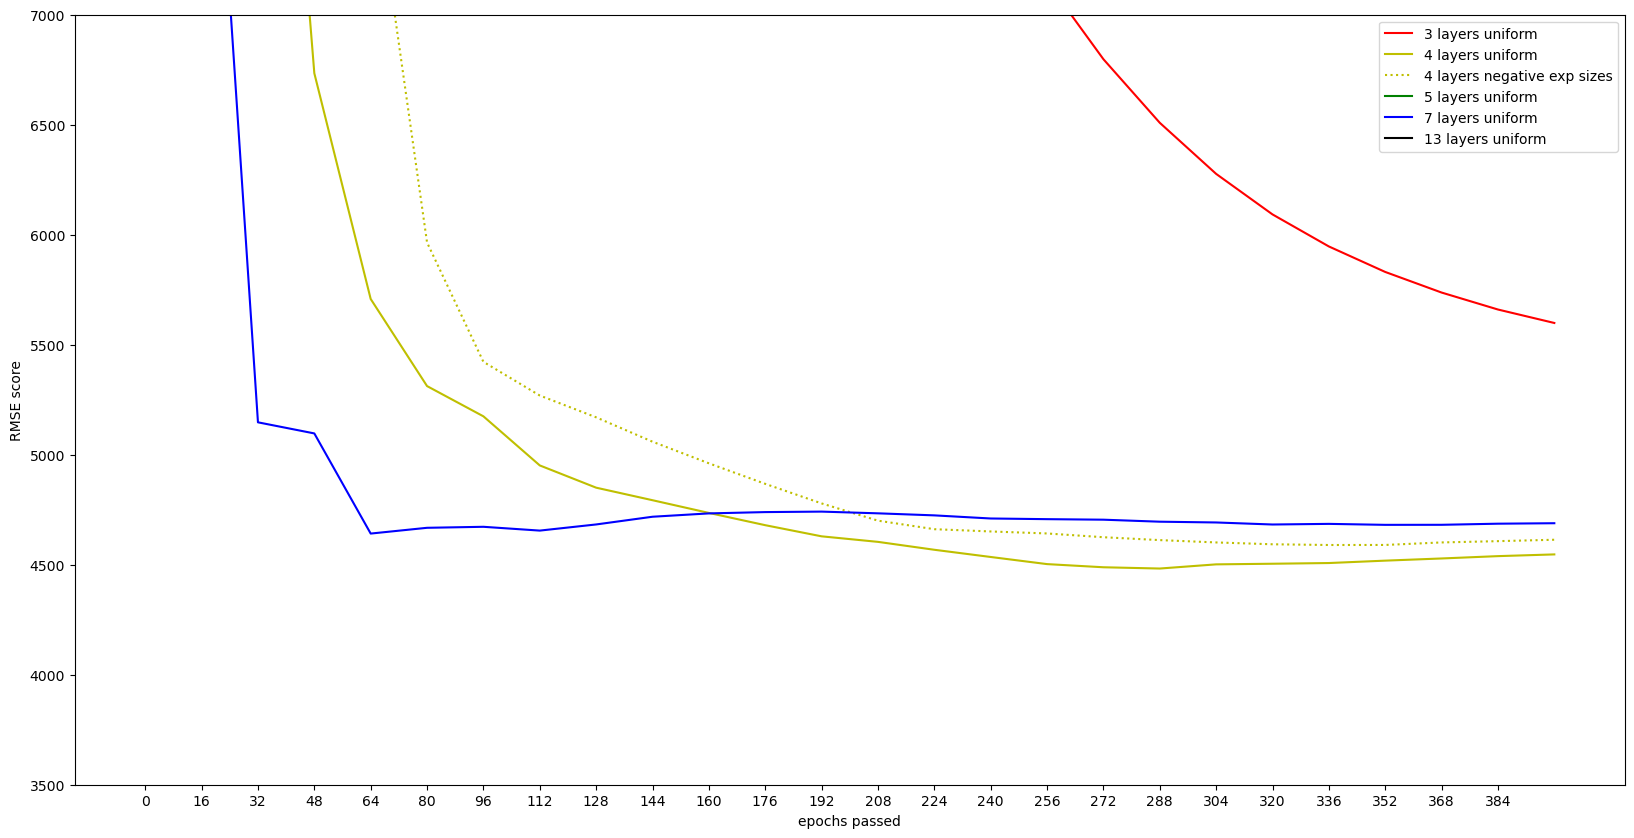

In [37]:
ts = TestSuit(tests,epochs={'epochs':400,'eval_rate':.04},random_state=35673567)
ts.run() 
ts.plot(ylim=(3500,7_000),figsize=(20,10), styles=['r', 'y', 'y:', 'g', 'b', 'k'] )

В общем, можно сделать вывод, что чем больше слоев в сети, тем менее она стабильна. 
При некоторых  стартовых счетчиках сети 5+ слоев (зеленый, синий, черный  графики) вообще не смогли начать реальное обучение за 400 эпох, оставшись с r2 < -1. Хотя , если  рубеж -1 преодолен, дляних можно ожидать быстрое обучение.
Трёхслойная сеть самая тупая. но и самая стабильная.  
Все же, я считаю настолько нестабильные модели (срыв в одном случае из 3х) непригодными  
Для дальнейшего тестирования остаются сети на 3-5 слоев с равномерным убыванием нейронов

Прогоним длинный тест , чтобы посмотреть , что происходит при большом увеличении количество эпох (10_000 эпох через 200)

In [38]:
%time
tests = [
    { 'levels': [13,5,1], 'label' : '3 layers uniform'},
    { 'levels': [13,8,4,1], 'label' : '4 layers uniform'},
    { 'levels': [13,10,7,4,1], 'label' : '5 layers uniform'}
]
ts = TestSuit(tests,epochs={'epochs':10_000,'eval_rate':.02})
ts.run()  

CPU times: total: 0 ns
Wall time: 0 ns
---> Testing with params {'epochs': 10000, 'eval_rate': 0.02, 'levels': [13, 5, 1], 'label': '3 layers uniform'}
epoch 0,	metric 14193.3516
epoch 200,	metric 7818.5508
epoch 400,	metric 5415.2710
epoch 600,	metric 4982.1255
epoch 800,	metric 4797.5483
epoch 1000,	metric 4770.8979
epoch 1200,	metric 4689.4111
epoch 1400,	metric 4675.7495
epoch 1600,	metric 4607.7402
epoch 1800,	metric 4585.1509
epoch 2000,	metric 4588.3828
epoch 2200,	metric 4609.4443
epoch 2400,	metric 4629.7812
epoch 2600,	metric 4654.4165
epoch 2800,	metric 4662.3608
epoch 3000,	metric 4681.1465
epoch 3200,	metric 4692.2471
epoch 3400,	metric 4698.4717
epoch 3600,	metric 4713.2607
epoch 3800,	metric 4720.8516
epoch 4000,	metric 4726.4043
epoch 4200,	metric 4718.2129
epoch 4400,	metric 4720.5869
epoch 4600,	metric 4718.0630
epoch 4800,	metric 4712.9072
epoch 5000,	metric 4709.0098
epoch 5200,	metric 4710.7041
epoch 5400,	metric 4709.7031
epoch 5600,	metric 4714.2017
epoch 5800,	m

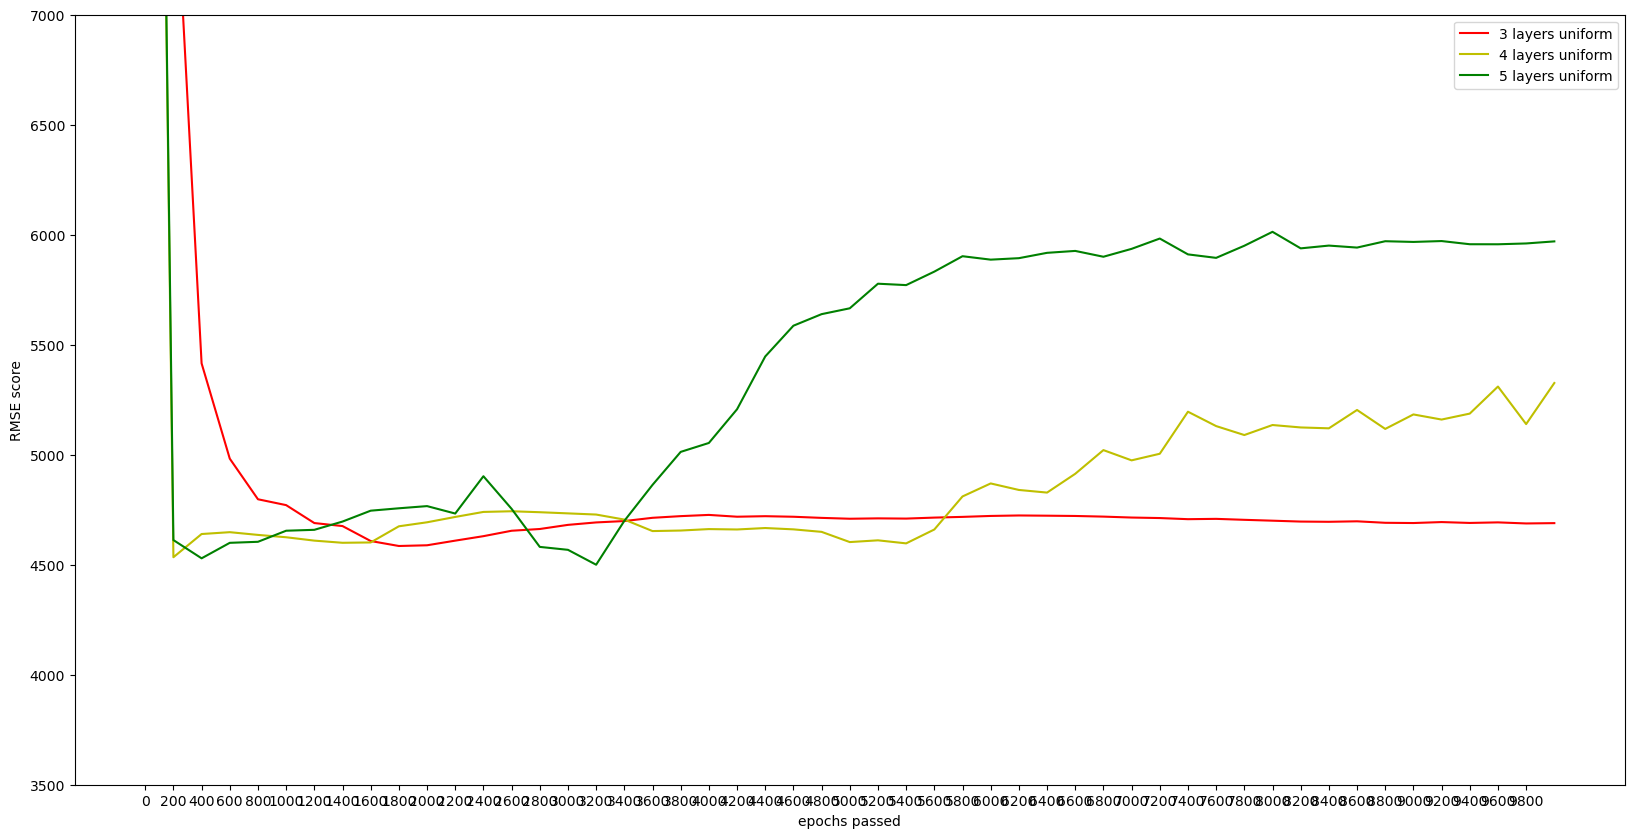

In [39]:
ts.plot(ylim=(3500,7000),figsize=(20,10), styles=['r', 'y', 'g'] )

Чем больше слоев , тем раньше начинается переобучение  
исходя из графиков , наиболее перспективна 4- слойная модель с 5000 эпох 

### Тест параметров инициализации

Затем проверим , насколько могут повлиять на резултат более тонкие параметры - скорость обучения и способ инициализации.   
(я предполагаю , что их влияние меньше, чем влияние макроструктуры сети)  
Следуюший класс прогоняет тесты на нескольких скоростях с 6 вариантами инициалзации на каждой:
нормальная / равномерная инициализация весов и для каждой 3 опции       
fan_in, fan_out, попеременно fan_in/fan_out на соседних слоях

In [40]:
class TestLearnRate:
    def __init__(self,learn_rates,params,epochs={'epochs':2600,'eval_rate':.2},random_state=55555):
        self.learn_rates = learn_rates  
        self.params= params
        self.epochs= epochs                # the same step for all tests  
        self.results = {}
        self.random_state = random_state
        

    def run(self):
        for methods in [[nn.init.kaiming_uniform_],[nn.init.kaiming_normal_]]:
            meth_names = list( map(lambda m: m.__name__[8:-1] ,methods) )
            for fan in [['fan_in'],['fan_out'],['fan_in','fan_out']]:
                label = '|'.join(meth_names)+'__'+'|'.join(fan) 
                serie = []
                for learn_rate  in self.learn_rates:            
                    params=self.epochs|self.params|{'learn_rate':learn_rate,'init_methods':methods,'fans':fan,'label':label}                               
                    t = Teacher(params,random_state=self.random_state)
                    t.run()
                    serie.append(t.best)
                self.results[label] = serie 

    def plot(self,ylim=(3500,7000),figsize=(20,8),styles=[*'rygbkm']):
        fig ,ax = plt.subplots( figsize=figsize )
        ax.set_ylim(ylim)
        styles.reverse()
        ax.set_title('Зависимость метрики RMSE от скорости обучения при различных параметрах инициализации ')
        ax.set_xlabel('learn_rate')
        ax.set_ylabel('rmse для температуры звезды')
        ticks = self.learn_rates
        ax.set_xticks(ticks)    

        for (l,r)  in self.results.items():
            ax.plot( self.learn_rates,r , styles.pop() ,label=l) 
        ax.legend() ; 



Для каждой скорости прогоняется тест на полное количество эпох и оценивается финальный результат (~30 минут )

In [41]:
%%time
t4 = TestLearnRate([.01,.03,.06,.1,.15,.2,.27,.35],params={'levels': [13,9,5,1]},
                   epochs={'epochs':5000, 'eval_rate':.04}  ,random_state = 123456789 )
t4.run()

---> Testing with params {'epochs': 5000, 'eval_rate': 0.04, 'levels': [13, 9, 5, 1], 'learn_rate': 0.01, 'init_methods': [<function kaiming_uniform_ at 0x0000021B65DD2F70>], 'fans': ['fan_in'], 'label': 'uniform__fan_in'}
epoch 0,	metric 14193.8174
epoch 200,	metric 11331.4395
epoch 400,	metric 5948.2334
epoch 600,	metric 5331.5737
epoch 800,	metric 5016.5059
epoch 1000,	metric 4825.3999
epoch 1200,	metric 4760.6816
epoch 1400,	metric 4665.7393
epoch 1600,	metric 4615.1968
epoch 1800,	metric 4582.6035
epoch 2000,	metric 4545.4761
epoch 2200,	metric 4552.1089
epoch 2400,	metric 4585.7876
epoch 2600,	metric 4653.4424
epoch 2800,	metric 4761.4556
epoch 3000,	metric 4761.9312
epoch 3200,	metric 4695.5361
epoch 3400,	metric 4604.6470
epoch 3600,	metric 4527.2095
epoch 3800,	metric 4466.9199
epoch 4000,	metric 4427.9429
epoch 4200,	metric 4402.3369
epoch 4400,	metric 4377.8750
epoch 4600,	metric 4357.0811
epoch 4800,	metric 4339.4941
epoch 4999,	metric 4326.0391
best 4326.0391 	 (best epoch

epoch 200,	metric 11086.5996
epoch 400,	metric 5917.0195
epoch 600,	metric 5351.0547
epoch 800,	metric 5021.5288
epoch 1000,	metric 4823.5493
epoch 1200,	metric 4741.6997
epoch 1400,	metric 4644.0669
epoch 1600,	metric 4582.4790
epoch 1800,	metric 4525.4370
epoch 2000,	metric 4474.0020
epoch 2200,	metric 4453.6421
epoch 2400,	metric 4459.9155
epoch 2600,	metric 4465.8193
epoch 2800,	metric 4486.7568
epoch 3000,	metric 4505.6167
epoch 3200,	metric 4514.5103
epoch 3400,	metric 4528.0415
epoch 3600,	metric 4544.7349
epoch 3800,	metric 4556.1152
epoch 4000,	metric 4567.2256
epoch 4200,	metric 4576.3613
epoch 4400,	metric 4584.8701
epoch 4600,	metric 4593.4199
epoch 4800,	metric 4599.0669
epoch 4999,	metric 4614.6904
best 4453.6421 	 (best epoch: 2200 ) ---> 
---> Testing with params {'epochs': 5000, 'eval_rate': 0.04, 'levels': [13, 9, 5, 1], 'learn_rate': 0.03, 'init_methods': [<function kaiming_uniform_ at 0x0000021B65DD2F70>], 'fans': ['fan_out'], 'label': 'uniform__fan_out'}
epoch 0,	m

epoch 600,	metric 5341.5186
epoch 800,	metric 5021.4351
epoch 1000,	metric 4827.9668
epoch 1200,	metric 4762.5713
epoch 1400,	metric 4659.8809
epoch 1600,	metric 4620.0723
epoch 1800,	metric 4581.3940
epoch 2000,	metric 4547.0327
epoch 2200,	metric 4582.3369
epoch 2400,	metric 4636.6382
epoch 2600,	metric 4671.9204
epoch 2800,	metric 4673.3799
epoch 3000,	metric 4628.7290
epoch 3200,	metric 4556.2451
epoch 3400,	metric 4496.5264
epoch 3600,	metric 4465.6426
epoch 3800,	metric 4451.5674
epoch 4000,	metric 4441.4492
epoch 4200,	metric 4465.4199
epoch 4400,	metric 4498.3564
epoch 4600,	metric 4527.0269
epoch 4800,	metric 4568.4614
epoch 4999,	metric 4605.3916
best 4441.4492 	 (best epoch: 4000 ) ---> 
---> Testing with params {'epochs': 5000, 'eval_rate': 0.04, 'levels': [13, 9, 5, 1], 'learn_rate': 0.03, 'init_methods': [<function kaiming_uniform_ at 0x0000021B65DD2F70>], 'fans': ['fan_in', 'fan_out'], 'label': 'uniform__fan_in|fan_out'}
epoch 0,	metric 14193.5664
epoch 200,	metric 5575.

epoch 400,	metric 5684.9502
epoch 600,	metric 5163.3979
epoch 800,	metric 4876.5488
epoch 1000,	metric 4753.8823
epoch 1200,	metric 4660.1260
epoch 1400,	metric 4616.5142
epoch 1600,	metric 4557.0825
epoch 1800,	metric 4537.3784
epoch 2000,	metric 4556.9302
epoch 2200,	metric 4589.9395
epoch 2400,	metric 4621.8667
epoch 2600,	metric 4647.3315
epoch 2800,	metric 4658.7856
epoch 3000,	metric 4669.0654
epoch 3200,	metric 4681.6562
epoch 3400,	metric 4689.5435
epoch 3600,	metric 4695.1523
epoch 3800,	metric 4692.4131
epoch 4000,	metric 4691.8760
epoch 4200,	metric 4695.0381
epoch 4400,	metric 4696.0020
epoch 4600,	metric 4694.1284
epoch 4800,	metric 4694.0352
epoch 4999,	metric 4694.1514
best 4537.3784 	 (best epoch: 1800 ) ---> 
---> Testing with params {'epochs': 5000, 'eval_rate': 0.04, 'levels': [13, 9, 5, 1], 'learn_rate': 0.03, 'init_methods': [<function kaiming_normal_ at 0x0000021B65DD9040>], 'fans': ['fan_in'], 'label': 'normal__fan_in'}
epoch 0,	metric 14192.3271
epoch 200,	metri

epoch 1200,	metric 4601.4795
epoch 1400,	metric 4551.2329
epoch 1600,	metric 4481.0435
epoch 1800,	metric 4486.1836
epoch 2000,	metric 4539.2119
epoch 2200,	metric 4583.2090
epoch 2400,	metric 4613.2295
epoch 2600,	metric 4636.4561
epoch 2800,	metric 4628.2939
epoch 3000,	metric 4636.9897
epoch 3200,	metric 4604.5928
epoch 3400,	metric 4562.0210
epoch 3600,	metric 4533.7212
epoch 3800,	metric 4498.0762
epoch 4000,	metric 4452.0449
epoch 4200,	metric 4401.3525
epoch 4400,	metric 4339.8491
epoch 4600,	metric 4329.6211
epoch 4800,	metric 4333.9307
epoch 4999,	metric 4351.5947
best 4329.6211 	 (best epoch: 4600 ) ---> 
---> Testing with params {'epochs': 5000, 'eval_rate': 0.04, 'levels': [13, 9, 5, 1], 'learn_rate': 0.03, 'init_methods': [<function kaiming_normal_ at 0x0000021B65DD9040>], 'fans': ['fan_out'], 'label': 'normal__fan_out'}
epoch 0,	metric 14189.2510
epoch 200,	metric 5240.3076
epoch 400,	metric 4633.5952
epoch 600,	metric 4499.4019
epoch 800,	metric 4488.2676
epoch 1000,	met

epoch 1800,	metric 4542.9976
epoch 2000,	metric 4566.9956
epoch 2200,	metric 4601.1411
epoch 2400,	metric 4634.7432
epoch 2600,	metric 4655.4854
epoch 2800,	metric 4666.6694
epoch 3000,	metric 4679.0190
epoch 3200,	metric 4688.8555
epoch 3400,	metric 4689.5669
epoch 3600,	metric 4691.3296
epoch 3800,	metric 4694.1792
epoch 4000,	metric 4696.9717
epoch 4200,	metric 4700.9028
epoch 4400,	metric 4706.0005
epoch 4600,	metric 4693.4624
epoch 4800,	metric 4681.0078
epoch 4999,	metric 4634.4248
best 4542.9976 	 (best epoch: 1800 ) ---> 
---> Testing with params {'epochs': 5000, 'eval_rate': 0.04, 'levels': [13, 9, 5, 1], 'learn_rate': 0.03, 'init_methods': [<function kaiming_normal_ at 0x0000021B65DD9040>], 'fans': ['fan_in', 'fan_out'], 'label': 'normal__fan_in|fan_out'}
epoch 0,	metric 14191.9648
epoch 200,	metric 5316.8804
epoch 400,	metric 4653.7939
epoch 600,	metric 4507.8857
epoch 800,	metric 4477.3159
epoch 1000,	metric 4529.9253
epoch 1200,	metric 4568.5171
epoch 1400,	metric 4587.972

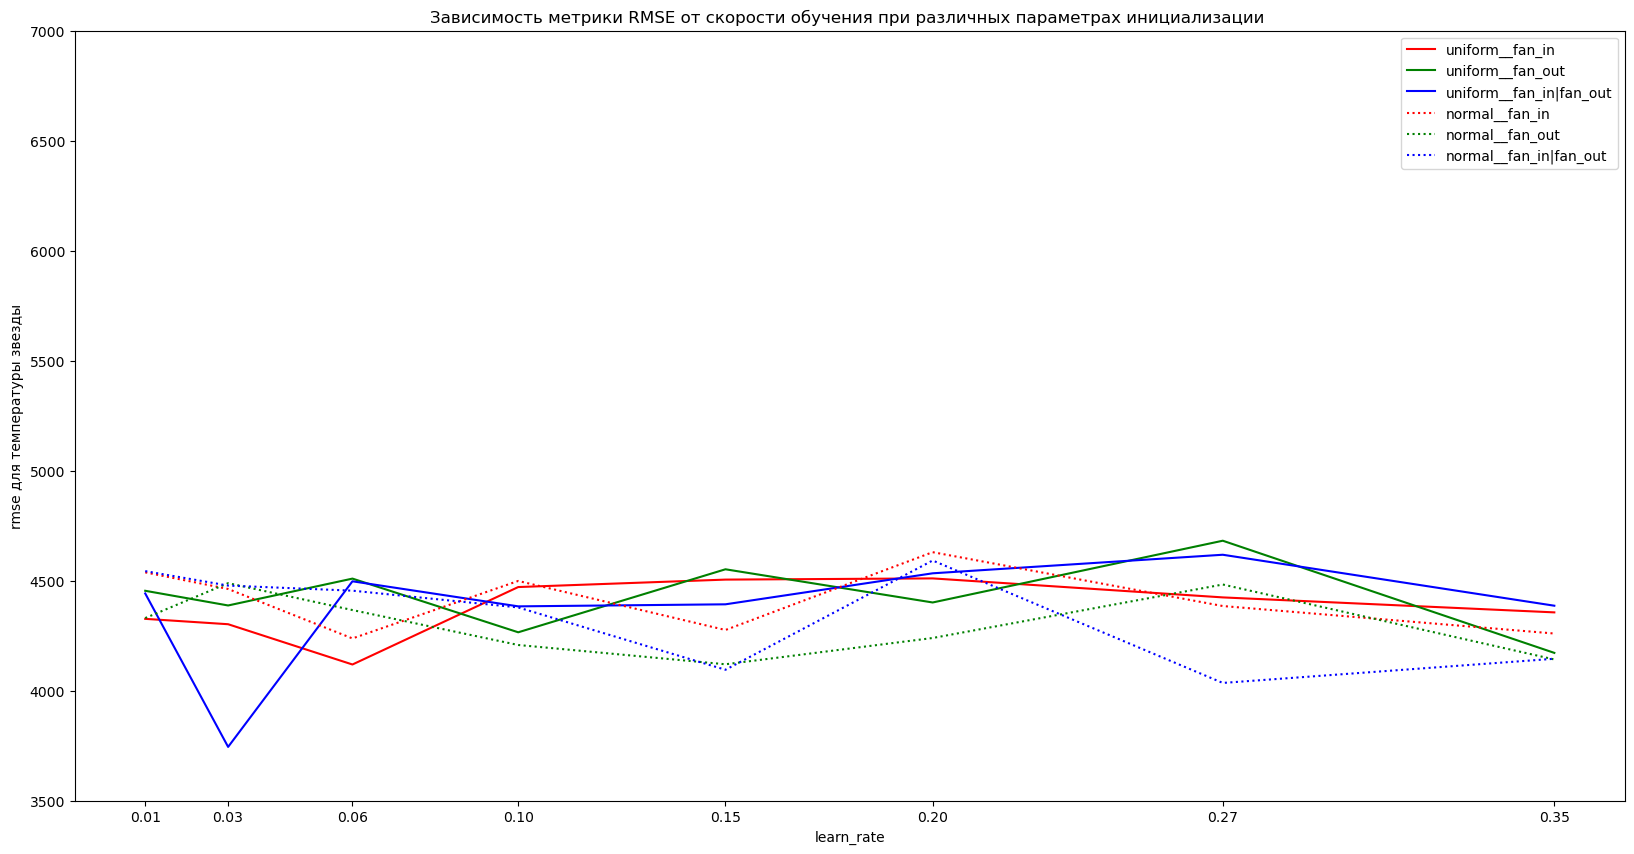

In [42]:
t4.plot(ylim=(3500,7000),figsize=(20,10), styles=['r', 'g', 'b', 'r:','g:','b:'])

Резльтаты близки и относительно мало зависят от параметров инициализации

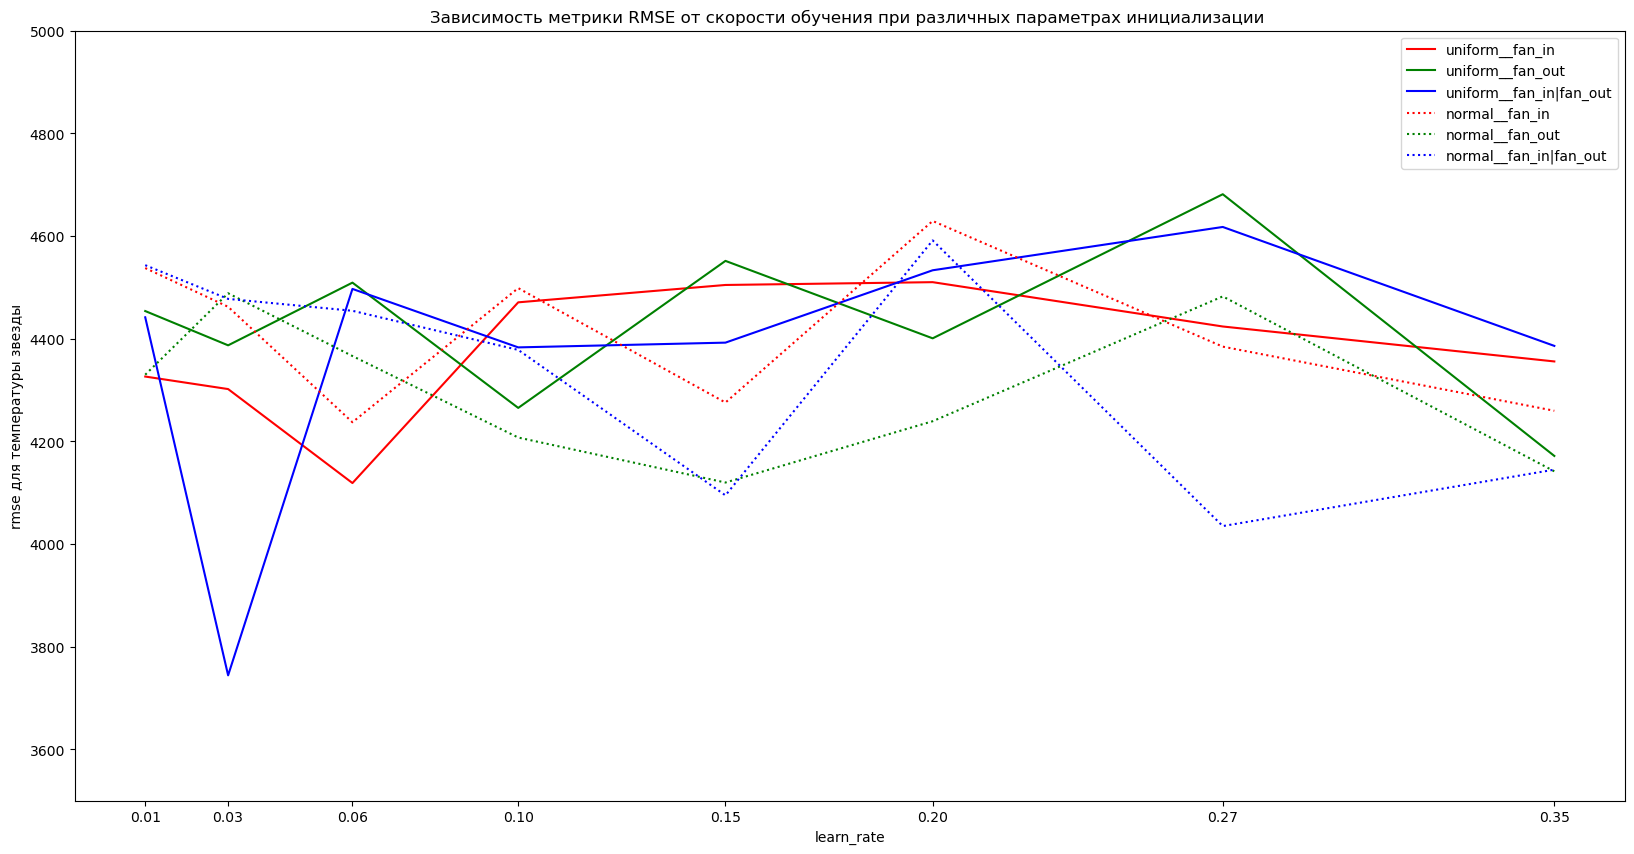

In [43]:
t4.plot(ylim=(3500,5000),figsize=(20,10), styles=['r', 'g', 'b', 'r:','g:','b:'])

Более близкий взгляд показывает колебания метрики в диапазоне 3700-4600 
Для финалного теста выбрана скорость .03  для линии  uniform initialization, fan_in| fan_out 

### Финальный тест

In [44]:
params={'levels': [13,9,5,1], 
        'learn_rate':.03,
        'init_methods':[nn.init.kaiming_uniform_],'fans':['fan_in','fan_out'],
        'epochs':4000, 'eval_rate':.04 
       }
t_final= Teacher( params,random_state=123456789 )
t_final.run()

---> Testing with params {'levels': [13, 9, 5, 1], 'learn_rate': 0.03, 'init_methods': [<function kaiming_uniform_ at 0x0000021B65DD2F70>], 'fans': ['fan_in', 'fan_out'], 'epochs': 4000, 'eval_rate': 0.04}
epoch 0,	metric 14193.5664
epoch 160,	metric 5832.4946
epoch 320,	metric 4961.8755
epoch 480,	metric 4698.4448
epoch 640,	metric 4584.3462
epoch 800,	metric 4481.5972
epoch 960,	metric 4411.9546
epoch 1120,	metric 4395.8540
epoch 1280,	metric 4429.4370
epoch 1440,	metric 4482.4644
epoch 1600,	metric 4502.1597
epoch 1760,	metric 4517.7231
epoch 1920,	metric 4531.0654
epoch 2080,	metric 4549.2119
epoch 2240,	metric 4583.5757
epoch 2400,	metric 4594.2847
epoch 2560,	metric 4463.7715
epoch 2720,	metric 4222.7769
epoch 2880,	metric 4129.1118
epoch 3040,	metric 4103.8130
epoch 3200,	metric 4068.6577
epoch 3360,	metric 3998.8613
epoch 3520,	metric 3916.5906
epoch 3680,	metric 3858.8044
epoch 3840,	metric 3799.2678
epoch 3999,	metric 3752.9377
best 3752.9377 	 (best epoch: 3999 ) ---> 


 Результат финального теста R2:0.8384, 	RMSE: 3753 


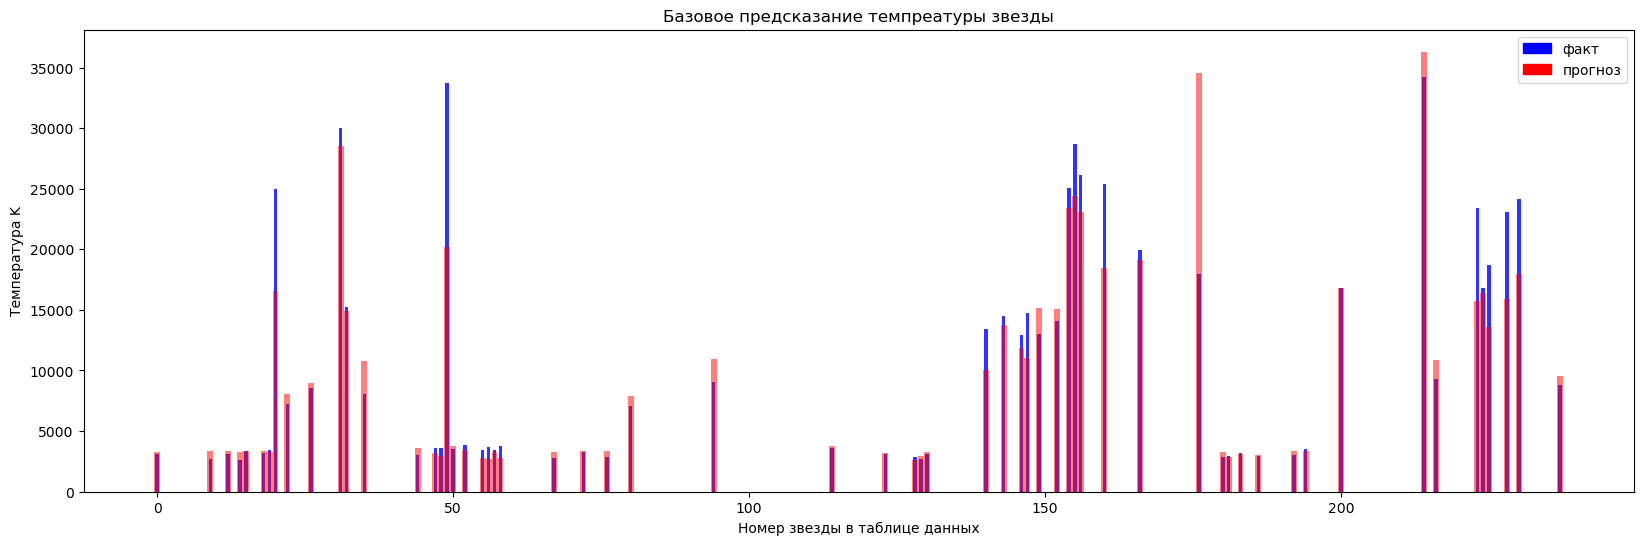

In [45]:
final_preds = t_final.final_preds.detach().numpy().flatten()
r2 = r2_score(y_te.numpy(),final_preds )
final_rmse = rmse(y_te.numpy(),final_preds )
print(f" Результат финального теста R2:{r2:.4f}, \tRMSE: {final_rmse:.0f} " )

plot_match_bar( pd.DataFrame({'target': y_te.numpy().flatten(),'pred':final_preds},index= i_te)
               ,'Базовое предсказание температуры звезды')

Картинка выглядит лучше, визуально ошибок для низкотемпературных звезд не видно, для высокотемпературных наблюдаются ошибки в обе стороны, более- менее сбалансированные  
Однако есть несколько объектов для которых прогноз  отличается от факта примерно вдвое 

## Выводы

* Для анализа использовался набор данных с 240 наблюдениями, 3мя числовыми и 2мя категориальными признаками
* Из них проверки модели использованы 60 наблюдений, стратифицированных по классу звезды 
* По результатам исследования лучшей оказалась четрехслойная модель с количеством нейронов 13-9-5-1
* Эта модель позволяет предсказывать температуру звезды с ошибкой меньше 4000 по метрике RMSE и метрикой R2=0.83 
* Для оптимального обучения модели требуется 4000 эпох при скорости обучения 0.03
* Модели без настройки гиперпараметров обычно предсказывают результат с метрикой r2=0.72-0.75, что хуже линейной регрессии 
* Возможно модели чувствительны к способу инициализации весов и даже к стартовому значению генератора случайных чисел; этот вопрос требует дополнительного исследования  